# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить любое из двух заданий

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

Необходимо написать функции `train_one_epoch`, `train` и `predict` по шаблонам ниже (во многом повторяют примеры с семинаров).Обратите особое внимание на функцию `predict`: она должна возвращать список лоссов по всем объектам даталоадера, список предсказанных классов для каждого объекта из даталоалера и список настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам. Если вы выполнили оба задания, то берется максимум из двух оценок.

__Бонус__. Вы получаете 5 бонусных баллов если справляетесь с обоими заданиями на 10 баллов (итого 15 баллов). В противном случае выставляется максимальная из двух оценок и ваш бонус равен нулю.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [2]:
import numpy as np
import torch
import torchvision
import tqdm
from torch import nn, optim
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm 
from torchvision import transforms
import PIL
import albumentations as A
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
np.random.seed(1)

### Подготовка данных

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform): 
        self.x = data_dir
        self.y = transform
    
    def __getitem__(self, idx):
        return [torch.tensor(self.x[idx, :], dtype=torch.float), torch.tensor(self.y[idx], dtype=torch.float)]
    
    def __len__(self):
        return len(self.x)
        

In [6]:
train_transform = transforms.Compose(
    [   
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.485, 0.456, 0.406))
    ]
)
val_transform = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.485, 0.456, 0.406))
    ]
)


train_dataset = torchvision.datasets.ImageFolder("../input/data-set/dataset/dataset/train", transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder("../input/data-set/dataset/dataset/val", transform=val_transform)

train_dataloader =  torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=60,
    shuffle=True, 
    num_workers=1
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=60,
    shuffle=False, 
    num_workers=1
)

In [7]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Вспомогательные функции, реализация модели

In [8]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label="train", zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [17]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device,train_loss_log, train_acc_log):
    train_epoch_loss, train_epoch_true_hits = torch.empty(0), torch.empty(0)
    model.train()
    
    for img, label in tqdm(train_dataloader):   
        img, label = img.to(device), label.to(device)
        
        y_pred = model(img)
        loss = criterion(y_pred, label)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_epoch_loss = torch.cat((train_epoch_loss, loss.unsqueeze(0).cpu() / label.size(0)))
        train_loss_log.append(loss.data / label.size(0))

        pred_classes = torch.argmax(y_pred, dim=-1)
        
        train_epoch_true_hits = torch.cat((
            train_epoch_true_hits, 
            (pred_classes == label).sum().unsqueeze(0).cpu()
            ))
        train_acc_log.append((pred_classes == label).cpu().sum() / label.shape[0])

def predict(model, val_dataloader, criterion, device):
    losses, predicted_classes, true_classes = [], [], []
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        for img, label in tqdm(val_dataloader):
            img, label = img.to(device), label.to(device)
            
            y_pred = model(img)
            loss = criterion(y_pred, label)
            losses.append(loss.item())
            
            und, pred_classes = torch.max(y_pred, 1)
            predicted_classes.extend(pred_classes.cpu().detach().numpy())
            true_classes.extend(label.cpu().detach().numpy())

    return losses, predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    model.to(device)
    
    for epoch in range(n_epochs):
        train_one_epoch(model, train_dataloader, criterion, optimizer, device,train_loss_log, train_acc_log)
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        
        with torch.no_grad():
            for img, label in tqdm(val_dataloader, desc=f"Validating, epoch {epoch}", leave=False):
                img, label = img.to(device), label.to(device)
                
                y_pred = model(img)
                loss = criterion(y_pred, label)
                val_epoch_loss = torch.cat((val_epoch_loss, loss.unsqueeze(0).cpu() / label.size(0)))

                pred_classes = torch.argmax(y_pred, dim=-1)
                val_epoch_true_hits = torch.cat((
                    val_epoch_true_hits,
                    (pred_classes == label).sum().unsqueeze(0).cpu()
                ))
        
        
        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size)
        
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")
        
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:", 
            (val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item()
        )

### Обучение модели, запуски экспериментов

In [18]:
model = nn.Sequential(
    nn.Conv2d(3, 60, 3, padding = 1),
    nn.BatchNorm2d(60),
    nn.ReLU(),
    nn.Conv2d(60, 60, 3, padding=1),
    nn.BatchNorm2d(60),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(60, 128, 3, padding = 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, 3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(128, 256, 3, padding = 1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, 3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(256, 512, 3, padding = 1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Conv2d(512, 512, 3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(8192, 4096),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(4096, 200)
    )

In [19]:
model = model
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = None
n_epochs = 16
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Простой тест на проверку правильности написанного кода

In [20]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

  0%|          | 0/167 [00:00<?, ?it/s]

tests passed


Запустить обучение можно в ячейке ниже.

  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 0:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5e216728c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5e216728c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

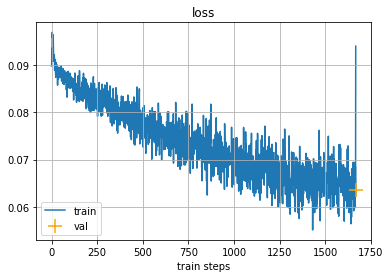

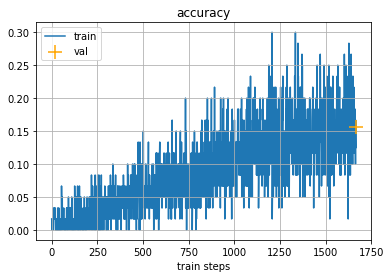

Val loss: 0.06362158060073853
Val acc: 0.15598802268505096


  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 1:   0%|          | 0/167 [00:00<?, ?it/s]

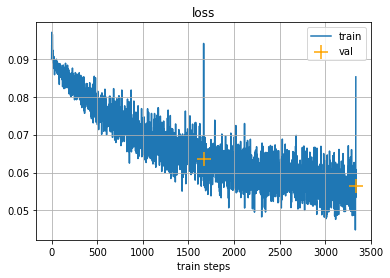

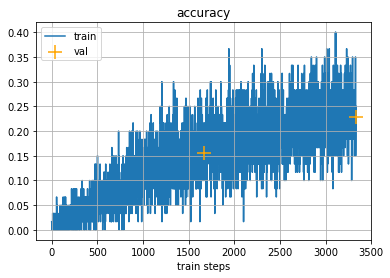

Val loss: 0.05631861835718155
Val acc: 0.22834330797195435


  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 2:   0%|          | 0/167 [00:00<?, ?it/s]

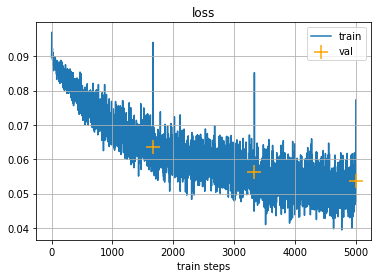

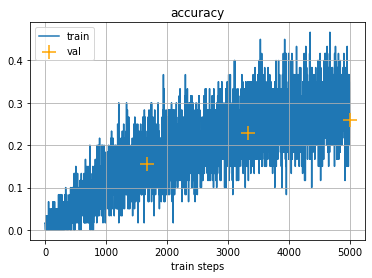

Val loss: 0.05370495095849037
Val acc: 0.26047903299331665


  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 3:   0%|          | 0/167 [00:00<?, ?it/s]

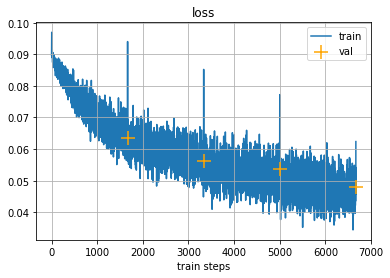

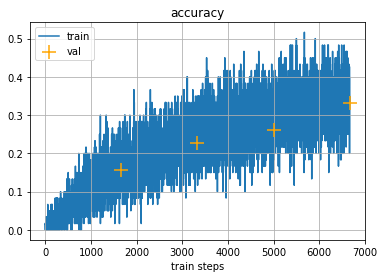

Val loss: 0.047872744500637054
Val acc: 0.3309381306171417


  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 4:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5e216728c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


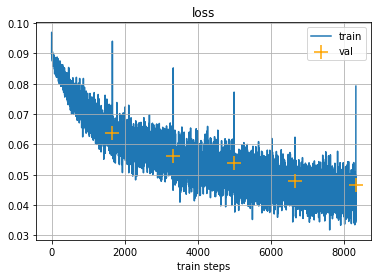

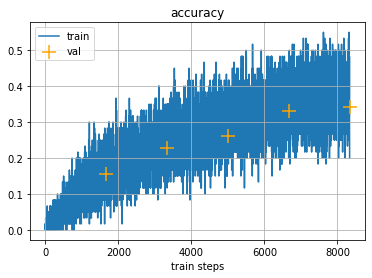

Val loss: 0.04672670736908913
Val acc: 0.3432135581970215


  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 5:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5e216728c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


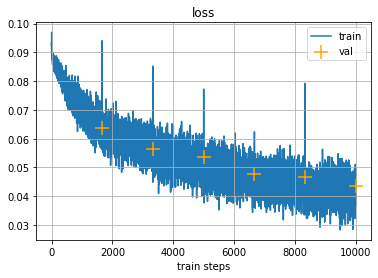

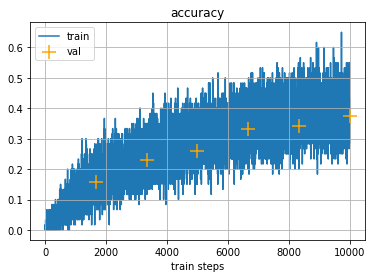

Val loss: 0.043718356639146805
Val acc: 0.3743513226509094


  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 6:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5e216728c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


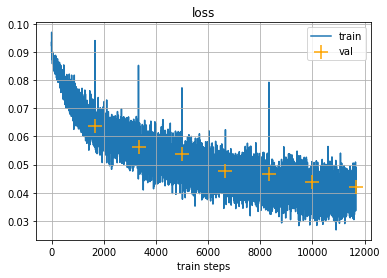

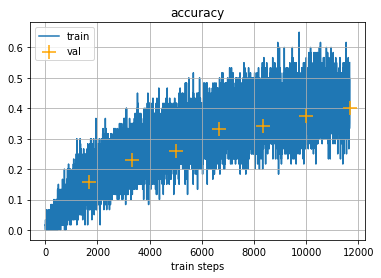

Val loss: 0.041862741112709045
Val acc: 0.4010978043079376


  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 7:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5e216728c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


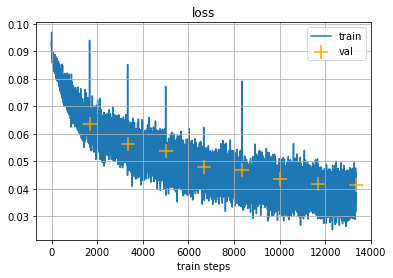

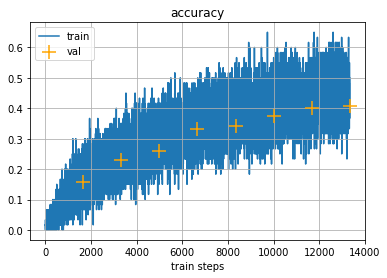

Val loss: 0.04150114953517914
Val acc: 0.4087824523448944


  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 8:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5e216728c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


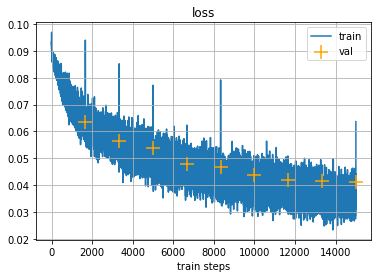

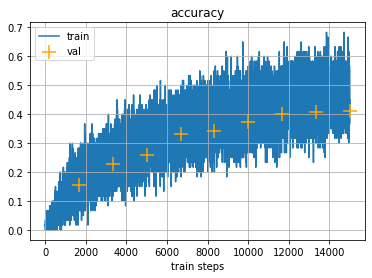

Val loss: 0.04123470559716225
Val acc: 0.4103792607784271


  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 9:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5e216728c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


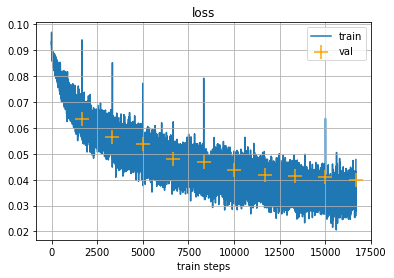

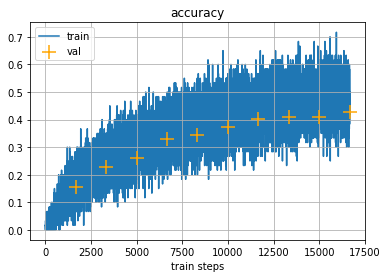

Val loss: 0.039749931544065475
Val acc: 0.42694610357284546


  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 10:   0%|          | 0/167 [00:00<?, ?it/s]

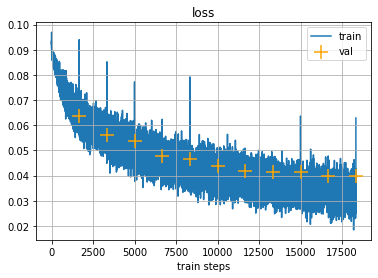

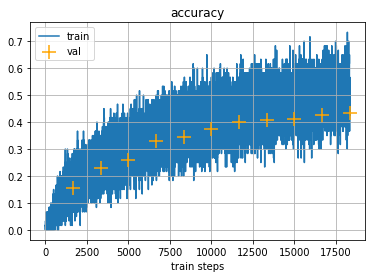

Val loss: 0.03979223221540451
Val acc: 0.43313372135162354


  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 11:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5e216728c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


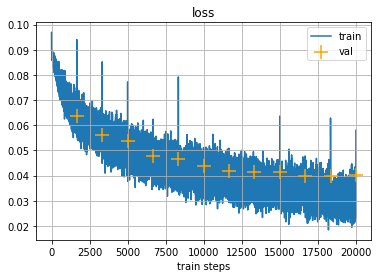

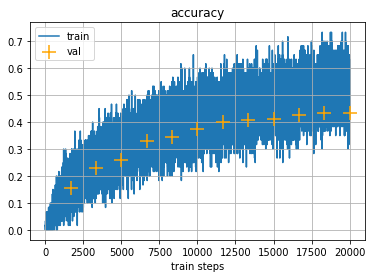

Val loss: 0.040056657046079636
Val acc: 0.4320359230041504


  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 12:   0%|          | 0/167 [00:00<?, ?it/s]

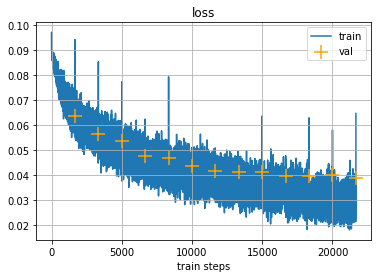

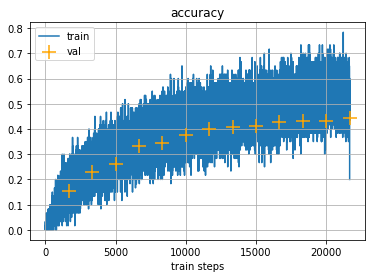

Val loss: 0.03903449326753616
Val acc: 0.44211578369140625


  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 13:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5e216728c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


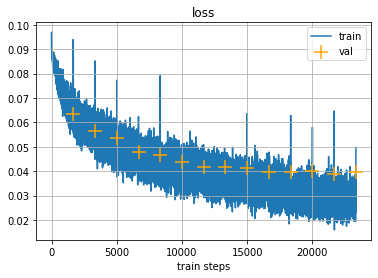

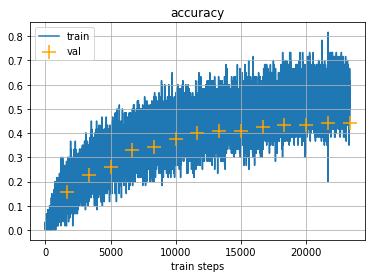

Val loss: 0.03963760659098625
Val acc: 0.44001996517181396


  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 14:   0%|          | 0/167 [00:00<?, ?it/s]

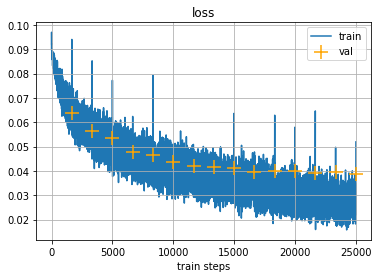

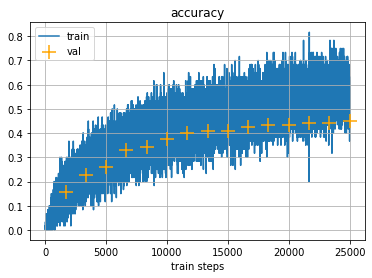

Val loss: 0.03892817348241806
Val acc: 0.4493013918399811


  0%|          | 0/1667 [00:00<?, ?it/s]

Validating, epoch 15:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5e216728c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


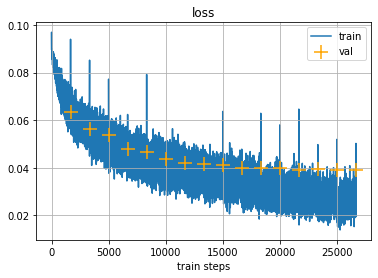

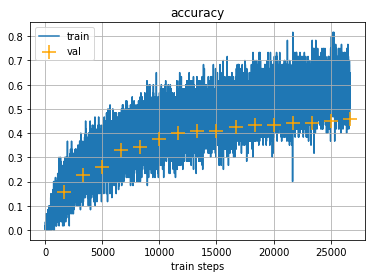

Val loss: 0.03890201449394226
Val acc: 0.45908182859420776


In [21]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs)

### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию `evaluate`. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [23]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Оценка за это задание составит {} баллов".format(min(10, 10 * accuracy / 0.44)))

  0%|          | 0/167 [00:00<?, ?it/s]

Оценка за это задание составит 10 баллов


### Отчёт об экспериментах 

По аналогии с прошлым домашним заданием, архитектура модели была заимствована с семинаров и отдельных кусков предобученных моделей. Однако, в этот раз, в отличии от 1 дз, делать выводы о качестве модели по первым 5 эпохам не получалось, поэтому отдельные гиперпараметры подбирались на подвыборке. Сильнее всего на качество и на сходимость повлиял шаг, который подбирался по сетке. В этот раз ReLU показал себя значительно лучше при измерении метрики качества accuracy, чем LeakyReLU. Самым значительным отличием от модели в прошлом дз является меньший разброс при изменении сида (возможно, повлияло то, что на качество предыдущей модели сильно влияли дропауты: по этой причине я добавлял их после каждого линейного слоя, а они, в свою очередь, являются основным источником случайности в модели)